In [1]:
y_feature = 'TotalGHGEmissions'

## 0. Preliminary
    0.1 Import
    0.2 Read CSV
    0.3 Functions
        0.3.1 nan_volumetry
        0.3.2 print_feature_importances_shap_values
        0.3.3 regressor_grid
        0.3.4 regressor_result_DataFrame
        0.3.5 regressor
        0.3.6 regression_with_EnergyStarScore
        0.3.7 plot_r2_score
        0.3.8 r2_mean_barplot

## 1. Preparation DataFrame
    1.1 Standard scaler
    1.2 Train test k-fold split

## 2. Regressor
    2.1 DummyRegressor
    2.2 Linear Regression
    2.3 Elastic Net
    2.4 SVR
    2.5 RandomForestRegressor
    2.6 GradientBostingRegressor
    2.7 XGBoost
    2.8 LGBMRegressor
    2.9 regression_results_data.sort_values('R2_mean')

## 3. EnergyStarScore
    3.1 Best estimator and best param grid
    3.2 EneryStarScore not NaN
    3.3 EnergyStarScore median
    3.4 Overfitting

## 0. Preliminary

### 0.1 Import

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import shap
shap.initjs()

### 0.2 Read CSV

In [3]:
df = pd.read_csv('df_clean.csv')

pd.set_option('display.max_columns', None)

### 0.3 Functions

In [4]:
def nan_volumetry(df, title='NaN Volumetry'):
    """
    Plot a barh graph of NaN percentage values of every columns
    
    """
    plt.rcParams["figure.figsize"] =(10,len(df.columns)/3)
    per_1 = (df.isna().mean().round(4) * 100).sort_values()
    f, ax = plt.subplots()
    for i,item in enumerate(zip(per_1.keys(),per_1.values)):
        ax.barh(item[0], item[1], label = item[0])
        ax.text(1.5,i-0.2, str(item[1])+'%')
    plt.title(title, fontsize=20)
    plt.margins(0)
    plt.xlabel('Percentage')
    plt.ylabel('Columns')
    plt.grid(axis='x')
    plt.show()

In [5]:
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    shap_df = pd.DataFrame(columns= ['Feature', 'Feature_Importance'])
    for k, v in feature_importances.items():
        shap_df = shap_df.append({'Feature':k, 'Feature_Importance':v}, ignore_index=True)
    display(shap_df.head(10))
    return shap_df

In [6]:
from sklearn.metrics import mean_squared_error #squared: If True returns MSE value, if False returns RMSE value.
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import d2_absolute_error_score


def regressor_grid(X_train, y_train, X_test, y_test, Estimator, param_grid, score, cv, regressor_results, param_DataFrame):
    tic = time.time()
    
    grid = model_selection.GridSearchCV(eval(Estimator),
                                        param_grid,
                                        scoring=score,
                                        cv=cv
                                       )
    grid.fit(X_train, y_train)
    
    
    
    y_pred = grid.predict(X_test)
    grid_best_score = grid.best_score_
#     display(pd.DataFrame.from_dict(grid.cv_results_))
    RMSE = mean_squared_error(y_test, y_pred, squared=False) #squared: If True returns MSE value, if False returns RMSE value.
    R2 = r2_score(y_test, y_pred)
    MAX_ERROR = max_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    D2 = d2_absolute_error_score(y_test, y_pred)
    
    toc = time.time()
    x = pd.DataFrame({'Estimator' : [Estimator],                      
                      'R2' : [R2],
                      'RMSE' : [RMSE],
                      'Time_min' : [(toc-tic)/60]
                     }) 
    
    regressor_results = pd.concat([regressor_results,x], ignore_index=True)
    display(regressor_results)
    
    x = pd.DataFrame()
    for key,value in grid.best_params_.items():
        x[key] = [value]
        
    x['grid_best_score'] = grid_best_score
    x['score'] = R2
    param_DataFrame = pd.concat([param_DataFrame,x], ignore_index=True)

    
    return regressor_results, param_DataFrame

In [7]:
 def regressor_result_DataFrame():
    return pd.DataFrame(columns =['Estimator', 
                                  'R2', 
                                  'RMSE', 
                                  'Time_min'])

In [8]:
def regressor(split_dict, Estimator, param_grid, param_DataFrame_dic, score='r2', cv=5):
    for key, values in split_dict.items():
        print('\n'+key+' :')
        values[4], param_DataFrame_dic[Estimator] = regressor_grid(values[0], values[1], values[2], values[3],
                                                                   Estimator,
                                                                   param_grid,
                                                                   score,
                                                                   cv,
                                                                   values[4],
                                                                   param_DataFrame_dic[Estimator]
                                                                  )
    print("\n\nPARAM_GRID_RESULTS:")
    param_DataFrame_dic[Estimator].insert(0, "Fold#", split_dict.keys())
    display(param_DataFrame_dic[Estimator])
    plot_r2_score(param_DataFrame_dic[Estimator],title=Estimator)

In [9]:
def regression_with_EnergyStarScore(data, features, y_feature, Estimator, param_grid, add_to_estimator_name, regression_results_data):
    X = data[features]
    y = data[y_feature]
    
    
    skf = StratifiedKFold(shuffle=True)
    skf.get_n_splits(X, y)
    y_cut = pd.qcut(y,4, labels=False)
    
    train_test_dict={}
    EnergyStarScore_dict = {}
    i=0
    for train_index, test_index in skf.split(X, y_cut):   
        i+=1
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_std, X_test_std = standard_scaler(X_train, X_test)
        train_test_dict['Fold_'+str(i)] = [X_train_std,
                                           y_train,
                                           X_test_std,
                                           y_test
                                          ]
    grid = model_selection.GridSearchCV(eval(Estimator),
                                        param_grid,
                                        scoring='r2',
                                        cv=5
                                        )
    r2_results = []                                     
    rmse_results = []
    time_results = []
    results = {'Estimator':Estimator+add_to_estimator_name}
    EnergyStarScore_shap_df = pd.DataFrame(columns=['Fold','shap_rank','shap_value'])
    R2_score_GridSearchCV = pd.DataFrame(columns= ['Fold','grid_best_score','score'])
    i=0
    for key, values in train_test_dict.items():
        i+=1
        tic = time.time()
        grid.fit(values[0],values[1])
        y_pred = grid.predict(values[2])
        
        results[key+'_R2'] = r2_score(values[3],y_pred)
        r2_results.append(results[key+'_R2'])
        rmse_results.append(mean_squared_error(values[3],y_pred,squared=False))
        toc = time.time()
        time_results.append((toc-tic)/60)
        print('\n\n'+key+'\n'+'R2 score : '+ str(r2_score(values[3],y_pred))+'\n')
        explainer = shap.Explainer(grid.predict, values[2],feature_names=features)
        shap_values = explainer(values[2])
        shap_df = print_feature_importances_shap_values(shap_values, features)
        shap.plots.bar(shap_values)
        EnergyStarScore_dict[key] = [r2_score(values[3],y_pred), shap_df, shap_values]
            
        shap_index = ((shap_df.loc[shap_df['Feature']=='ENERGYSTARScore',:].index)[0])+1
        shap_value = float(shap_df.loc[shap_df['Feature']=='ENERGYSTARScore','Feature_Importance'])
        EnergyStarScore_shap_df = EnergyStarScore_shap_df.append({'Fold':key, 
                                                                  'shap_rank':shap_index, 
                                                                  'shap_value':shap_value}, ignore_index=True)
        grid_best_score = grid.best_score_
        x = pd.DataFrame({'Fold#':['Fold'+str(i)],
                         'grid_best_score':[grid_best_score],
                         'score':[results[key+'_R2']]
                        })
        R2_score_GridSearchCV = pd.concat([R2_score_GridSearchCV,x], ignore_index=True)
        
        
        
    results['R2_mean'] = np.mean(r2_results)
    results['RMSE_mean'] = np.mean(rmse_results)
    results['Time_mean'] = np.mean(time_results)
    
    regression_results_data = regression_results_data.append(results, ignore_index=True)
    regression_results_data.sort_values('R2_mean', ascending=False)
    
    return regression_results_data, EnergyStarScore_shap_df, EnergyStarScore_dict, R2_score_GridSearchCV

In [10]:
def plot_r2_score(data, title=''):
    plt.rcParams["figure.figsize"] = (3,3)
    plt.figure()
    plt.title('R2 Score '+title, fontsize=20)
    plt.xlabel('Fold',fontsize=10)
    plt.ylabel('R2',fontsize=10)
    
    X_axis = np.arange(len(data))
    width=1/5
    
    plt.bar(X_axis+width, data['grid_best_score'], width*2, label='GridSearchCV score')
    plt.bar(X_axis-width, data['score'], width*2, label='y_pred/y_test score')
    
    plt.xticks(X_axis, data['Fold#'])
    plt.ylim([0,1])
    plt.tick_params( length =5, labelsize=10)
    plt.grid(linewidth=0.5, color = 'black')
    plt.legend()
    plt.margins(0.001)
    plt.show()
    plt.close()

In [11]:
def r2_mean_barplot(data):
    plt.rcParams["figure.figsize"] = (3,3)
    plt.figure()
    plt.title('R2_mean', fontsize=20)
    plt.xlabel('Estimators',fontsize=10)
    plt.ylabel('R2',fontsize=10)
    
    X_axis = np.arange(len(data))
    width=1/2
    
    plt.barh(X_axis, data['R2_mean'], width)
    plt.yticks(X_axis, data['Estimator'])
    plt.xlim([0,1])
    plt.tick_params( length =5, labelsize=10)
    plt.grid(axis='x', linewidth=0.5, color = 'black')
    plt.margins(0.001)
    plt.show()
    plt.close()
    

## 1. Preparation DataFrame

### 1.1 Standard Scaler

In [12]:
from sklearn.preprocessing import StandardScaler

def standard_scaler(X_train, X_test):
    std_scale = StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    return X_train_std, X_test_std

### 1.2 Train test k-fold split

In [13]:
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold

split_dict = {} 

y = df[y_feature] 

features = df.drop(columns=['TotalGHGEmissions','SiteEUIWN(kBtu/sf)','ENERGYSTARScore']).columns.tolist()
X = df[features]

skf = StratifiedKFold(shuffle=True)
skf.get_n_splits(X, y)
i = 0
y_cut = pd.qcut(y,5, labels=False)
for train_index, test_index in skf.split(X, y_cut):   
    i+=1

    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train_std, X_test_std = standard_scaler(X_train, X_test)
    
    split_dict["Fold_"+str(i)] = [X_train_std,
                                  y_train,
                                  X_test_std,
                                  y_test,
                                  regressor_result_DataFrame()
                                 ]

## 2. Regressor

### 2.1 DummyRegressor
https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor



Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.033886,714.234668,0.000415



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.11061,324.012561,0.000416



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.040804,824.8725,0.000349



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.051509,489.828756,0.000333



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.027596,1113.977389,0.000416




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,strategy
0,Fold_1,-0.037236,-0.033886,median
1,Fold_2,-0.036524,-0.110610,median
2,Fold_3,-0.065779,-0.040804,median
3,Fold_4,-0.047506,-0.051509,median
4,Fold_5,-0.047064,-0.027596,median


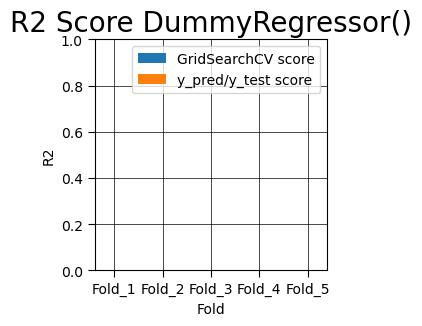

In [14]:
from sklearn.dummy import DummyRegressor
param_DataFrame_dic={}

Estimator = "DummyRegressor()"
param_grid = {'strategy' : ['mean', 'median','qauntile', 'constant']}
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))

regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)


### 2.2 Linear Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.033886,714.234668,0.000415
1,LinearRegression(),0.282430,595.027259,0.000366



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.110610,324.012561,0.000416
1,LinearRegression(),-2.045413,536.542550,0.000316



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.040804,824.872500,0.000349
1,LinearRegression(),0.286818,682.814238,0.000316



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.051509,489.828756,0.000333
1,LinearRegression(),0.138321,443.415172,0.000300



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.027596,1113.977389,0.000416
1,LinearRegression(),0.104039,1040.182855,0.001463




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score
0,Fold_1,NaN,NaN
1,Fold_2,NaN,NaN
2,Fold_3,NaN,NaN
3,Fold_4,NaN,NaN
4,Fold_5,NaN,NaN


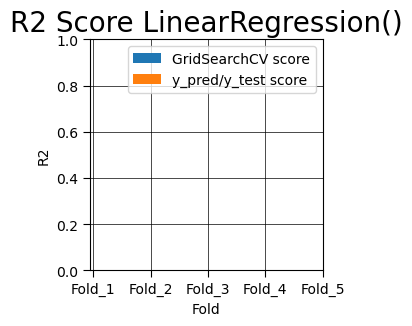

In [15]:
from sklearn.linear_model import LinearRegression

Estimator = "LinearRegression()"
param_grid = {}
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))


regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.3 Elastic Net
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.033886,714.234668,0.000415
1,LinearRegression(),0.282430,595.027259,0.000366
2,ElasticNet(),0.222607,619.333955,0.002288



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.110610,324.012561,0.000416
1,LinearRegression(),-2.045413,536.542550,0.000316
2,ElasticNet(),-0.421124,366.519476,0.002011



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.040804,824.872500,0.000349
1,LinearRegression(),0.286818,682.814238,0.000316
2,ElasticNet(),0.198053,724.061108,0.001995



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.051509,489.828756,0.000333
1,LinearRegression(),0.138321,443.415172,0.000300
2,ElasticNet(),0.174005,434.136842,0.002161



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.027596,1113.977389,0.000416
1,LinearRegression(),0.104039,1040.182855,0.001463
2,ElasticNet(),0.077244,1055.622552,0.002137




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,l1_ratio
0,Fold_1,0.111756,0.222607,0.10
1,Fold_2,0.158944,-0.421124,0.10
2,Fold_3,-0.141056,0.198053,0.10
3,Fold_4,0.122064,0.174005,0.10
4,Fold_5,0.155837,0.077244,0.19


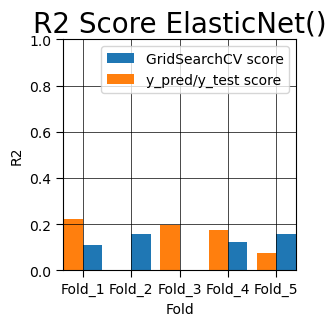

In [16]:
from sklearn.linear_model import ElasticNet

Estimator = "ElasticNet()"
param_grid = {'l1_ratio' : np.linspace(0.1,1,11).round(2)} 
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))


regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.4 SVR
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.033886,714.234668,0.000415
1,LinearRegression(),0.282430,595.027259,0.000366
2,ElasticNet(),0.222607,619.333955,0.002288
3,SVR(),0.084233,672.197803,0.037459



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.110610,324.012561,0.000416
1,LinearRegression(),-2.045413,536.542550,0.000316
2,ElasticNet(),-0.421124,366.519476,0.002011
3,SVR(),0.185115,277.542389,0.037206



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.040804,824.872500,0.000349
1,LinearRegression(),0.286818,682.814238,0.000316
2,ElasticNet(),0.198053,724.061108,0.001995
3,SVR(),0.070290,779.607791,0.039771



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.051509,489.828756,0.000333
1,LinearRegression(),0.138321,443.415172,0.000300
2,ElasticNet(),0.174005,434.136842,0.002161
3,SVR(),0.095613,454.270900,0.039573



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.027596,1113.977389,0.000416
1,LinearRegression(),0.104039,1040.182855,0.001463
2,ElasticNet(),0.077244,1055.622552,0.002137
3,SVR(),0.022876,1086.275694,0.039879




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,kernel,gamma
0,Fold_1,0.072396,0.084233,linear,scale
1,Fold_2,0.089579,0.185115,linear,scale
2,Fold_3,0.100678,0.070290,linear,scale
3,Fold_4,0.108800,0.095613,linear,scale
4,Fold_5,0.076500,0.022876,linear,scale


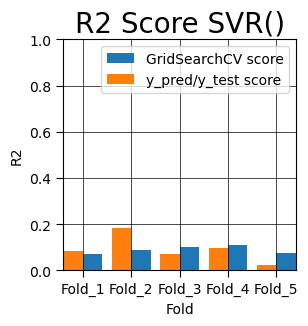

In [17]:
from sklearn.svm import SVR

Estimator = "SVR()"
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma' : ['scale','auto']
             }
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))



regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.5 RandomForestRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.033886,714.234668,0.000415
1,LinearRegression(),0.282430,595.027259,0.000366
2,ElasticNet(),0.222607,619.333955,0.002288
3,SVR(),0.084233,672.197803,0.037459
4,RandomForestRegressor(),0.444415,523.576377,1.617375



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.110610,324.012561,0.000416
1,LinearRegression(),-2.045413,536.542550,0.000316
2,ElasticNet(),-0.421124,366.519476,0.002011
3,SVR(),0.185115,277.542389,0.037206
4,RandomForestRegressor(),-0.015612,309.845398,1.635612



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.040804,824.872500,0.000349
1,LinearRegression(),0.286818,682.814238,0.000316
2,ElasticNet(),0.198053,724.061108,0.001995
3,SVR(),0.070290,779.607791,0.039771
4,RandomForestRegressor(),0.556732,538.313972,1.610322



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.051509,489.828756,0.000333
1,LinearRegression(),0.138321,443.415172,0.000300
2,ElasticNet(),0.174005,434.136842,0.002161
3,SVR(),0.095613,454.270900,0.039573
4,RandomForestRegressor(),0.165978,436.241220,1.639173



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.027596,1113.977389,0.000416
1,LinearRegression(),0.104039,1040.182855,0.001463
2,ElasticNet(),0.077244,1055.622552,0.002137
3,SVR(),0.022876,1086.275694,0.039879
4,RandomForestRegressor(),0.317585,907.798318,1.694019




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,criterion,n_estimators,n_jobs,min_samples_split,max_depth
0,Fold_1,0.414740,0.444415,poisson,2000,-1,5,3
1,Fold_2,0.429673,-0.015612,poisson,2000,-1,2,9
2,Fold_3,0.290575,0.556732,poisson,2000,-1,8,3
3,Fold_4,0.554235,0.165978,poisson,2000,-1,2,3
4,Fold_5,0.597882,0.317585,poisson,2000,-1,2,3


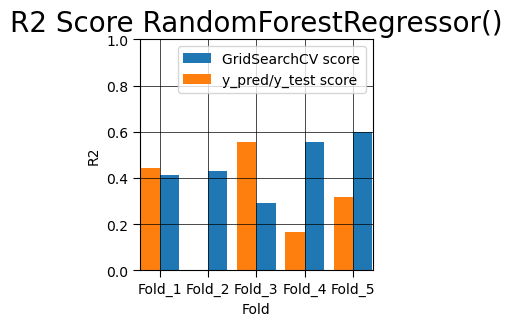

In [18]:
from sklearn.ensemble import RandomForestRegressor

Estimator = "RandomForestRegressor()"
param_grid = {'criterion' : ["poisson"],
              'n_estimators' : [2000],
              'n_jobs':[-1],
              'min_samples_split': [2,5,8] ,
              'max_depth':[3,6,9]
             }
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))



regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.6 GradientBoostingRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.033886,714.234668,0.000415
1,LinearRegression(),0.282430,595.027259,0.000366
2,ElasticNet(),0.222607,619.333955,0.002288
3,SVR(),0.084233,672.197803,0.037459
4,RandomForestRegressor(),0.444415,523.576377,1.617375
5,GradientBoostingRegressor(),0.468099,512.295000,3.629739



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.110610,324.012561,0.000416
1,LinearRegression(),-2.045413,536.542550,0.000316
2,ElasticNet(),-0.421124,366.519476,0.002011
3,SVR(),0.185115,277.542389,0.037206
4,RandomForestRegressor(),-0.015612,309.845398,1.635612
5,GradientBoostingRegressor(),0.745385,155.139773,3.704501



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.040804,824.872500,0.000349
1,LinearRegression(),0.286818,682.814238,0.000316
2,ElasticNet(),0.198053,724.061108,0.001995
3,SVR(),0.070290,779.607791,0.039771
4,RandomForestRegressor(),0.556732,538.313972,1.610322
5,GradientBoostingRegressor(),0.743595,409.416956,3.731887



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.051509,489.828756,0.000333
1,LinearRegression(),0.138321,443.415172,0.000300
2,ElasticNet(),0.174005,434.136842,0.002161
3,SVR(),0.095613,454.270900,0.039573
4,RandomForestRegressor(),0.165978,436.241220,1.639173
5,GradientBoostingRegressor(),0.216205,422.901261,3.633401



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.027596,1113.977389,0.000416
1,LinearRegression(),0.104039,1040.182855,0.001463
2,ElasticNet(),0.077244,1055.622552,0.002137
3,SVR(),0.022876,1086.275694,0.039879
4,RandomForestRegressor(),0.317585,907.798318,1.694019
5,GradientBoostingRegressor(),0.436017,825.273927,3.657470




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,loss,subsample,criterion,learning_rate,n_estimators,max_depth
0,Fold_1,0.481058,0.468099,huber,1.0,friedman_mse,0.01,500,5
1,Fold_2,0.519088,0.745385,huber,1.0,friedman_mse,0.01,500,5
2,Fold_3,0.392016,0.743595,huber,1.0,friedman_mse,0.01,500,5
3,Fold_4,0.652025,0.216205,squared_error,1.0,friedman_mse,0.01,500,3
4,Fold_5,0.622986,0.436017,squared_error,1.0,friedman_mse,0.01,500,5


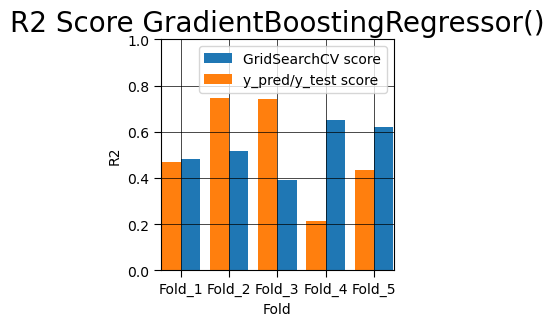

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

Estimator = "GradientBoostingRegressor()"
param_grid = {'loss' : ['squared_error', 'huber'],
              'subsample' : np.linspace(0.01,1,3).round(2),
              'criterion' : ['friedman_mse'],
              'learning_rate':np.linspace(0.01,1,3).round(2),
              'n_estimators':[500],
              'max_depth':[3,5]
             }
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))



regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.7 XGBoost

https://xgboost.readthedocs.io/en/stable/parameter.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.033886,714.234668,0.000415
1,LinearRegression(),0.282430,595.027259,0.000366
2,ElasticNet(),0.222607,619.333955,0.002288
3,SVR(),0.084233,672.197803,0.037459
4,RandomForestRegressor(),0.444415,523.576377,1.617375
5,GradientBoostingRegressor(),0.468099,512.295000,3.629739
6,xgb.XGBRegressor(),-0.064463,724.719434,0.576768



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.110610,324.012561,0.000416
1,LinearRegression(),-2.045413,536.542550,0.000316
2,ElasticNet(),-0.421124,366.519476,0.002011
3,SVR(),0.185115,277.542389,0.037206
4,RandomForestRegressor(),-0.015612,309.845398,1.635612
5,GradientBoostingRegressor(),0.745385,155.139773,3.704501
6,xgb.XGBRegressor(),0.305794,256.168153,0.618540



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.040804,824.872500,0.000349
1,LinearRegression(),0.286818,682.814238,0.000316
2,ElasticNet(),0.198053,724.061108,0.001995
3,SVR(),0.070290,779.607791,0.039771
4,RandomForestRegressor(),0.556732,538.313972,1.610322
5,GradientBoostingRegressor(),0.743595,409.416956,3.731887
6,xgb.XGBRegressor(),-0.069132,836.022797,0.625263



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.051509,489.828756,0.000333
1,LinearRegression(),0.138321,443.415172,0.000300
2,ElasticNet(),0.174005,434.136842,0.002161
3,SVR(),0.095613,454.270900,0.039573
4,RandomForestRegressor(),0.165978,436.241220,1.639173
5,GradientBoostingRegressor(),0.216205,422.901261,3.633401
6,xgb.XGBRegressor(),0.169949,435.201400,0.633378



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.027596,1113.977389,0.000416
1,LinearRegression(),0.104039,1040.182855,0.001463
2,ElasticNet(),0.077244,1055.622552,0.002137
3,SVR(),0.022876,1086.275694,0.039879
4,RandomForestRegressor(),0.317585,907.798318,1.694019
5,GradientBoostingRegressor(),0.436017,825.273927,3.657470
6,xgb.XGBRegressor(),0.429513,830.019189,0.624817




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,booster,eta,objective
0,Fold_1,-0.087722,-0.064463,gblinear,0.0,reg:squarederror
1,Fold_2,0.441643,0.305794,dart,0.9,reg:squarederror
2,Fold_3,-0.209008,-0.069132,gblinear,0.0,reg:squarederror
3,Fold_4,0.597534,0.169949,gbtree,0.1,reg:squarederror
4,Fold_5,0.521545,0.429513,gbtree,0.4,reg:squarederror


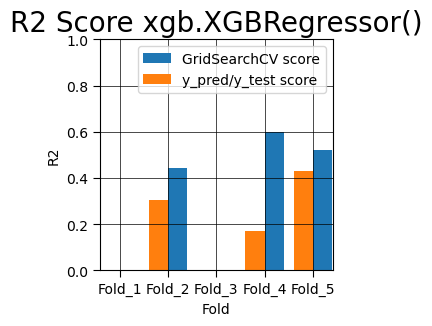

In [20]:
import xgboost as xgb


Estimator = "xgb.XGBRegressor()"
param_grid = {'booster' : ['gblinear', 'gbtree', 'dart'],
              'eta' : np.linspace(0,1,11).round(2),
              'objective': ['reg:squarederror']}
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))



regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.8 LGBMRegressor
https://lightgbm.readthedocs.io/en/latest/Parameters.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.033886,714.234668,0.000415
1,LinearRegression(),0.282430,595.027259,0.000366
2,ElasticNet(),0.222607,619.333955,0.002288
3,SVR(),0.084233,672.197803,0.037459
4,RandomForestRegressor(),0.444415,523.576377,1.617375
5,GradientBoostingRegressor(),0.468099,512.295000,3.629739
6,xgb.XGBRegressor(),-0.064463,724.719434,0.576768
7,lgb.LGBMRegressor(),0.344679,568.632390,0.409489



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.110610,324.012561,0.000416
1,LinearRegression(),-2.045413,536.542550,0.000316
2,ElasticNet(),-0.421124,366.519476,0.002011
3,SVR(),0.185115,277.542389,0.037206
4,RandomForestRegressor(),-0.015612,309.845398,1.635612
5,GradientBoostingRegressor(),0.745385,155.139773,3.704501
6,xgb.XGBRegressor(),0.305794,256.168153,0.618540
7,lgb.LGBMRegressor(),0.661110,178.982546,0.422458



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.040804,824.872500,0.000349
1,LinearRegression(),0.286818,682.814238,0.000316
2,ElasticNet(),0.198053,724.061108,0.001995
3,SVR(),0.070290,779.607791,0.039771
4,RandomForestRegressor(),0.556732,538.313972,1.610322
5,GradientBoostingRegressor(),0.743595,409.416956,3.731887
6,xgb.XGBRegressor(),-0.069132,836.022797,0.625263
7,lgb.LGBMRegressor(),0.330255,661.694000,0.439352



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.051509,489.828756,0.000333
1,LinearRegression(),0.138321,443.415172,0.000300
2,ElasticNet(),0.174005,434.136842,0.002161
3,SVR(),0.095613,454.270900,0.039573
4,RandomForestRegressor(),0.165978,436.241220,1.639173
5,GradientBoostingRegressor(),0.216205,422.901261,3.633401
6,xgb.XGBRegressor(),0.169949,435.201400,0.633378
7,lgb.LGBMRegressor(),0.212863,423.802015,0.419198



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.027596,1113.977389,0.000416
1,LinearRegression(),0.104039,1040.182855,0.001463
2,ElasticNet(),0.077244,1055.622552,0.002137
3,SVR(),0.022876,1086.275694,0.039879
4,RandomForestRegressor(),0.317585,907.798318,1.694019
5,GradientBoostingRegressor(),0.436017,825.273927,3.657470
6,xgb.XGBRegressor(),0.429513,830.019189,0.624817
7,lgb.LGBMRegressor(),0.261328,944.476550,0.437731




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,boosting_type,learning_rate,objective
0,Fold_1,0.459121,0.344679,goss,0.80,regression_l1
1,Fold_2,0.478258,0.661110,dart,1.00,regression_l1
2,Fold_3,0.384853,0.330255,dart,0.60,regression_l1
3,Fold_4,0.532160,0.212863,dart,0.11,regression
4,Fold_5,0.580102,0.261328,gbdt,0.50,regression


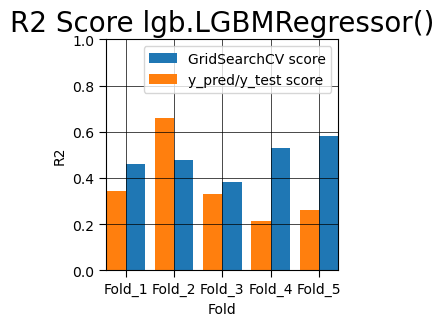

In [21]:
import lightgbm as lgb


Estimator = "lgb.LGBMRegressor()"
param_grid = {'boosting_type' : ['gbdt', 'dart', 'goss'],
              'learning_rate' : np.linspace(0.01,1,11).round(2),
              'objective': ['regression', 'regression_l1']}
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))



regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.9 regression_results_data.sort_values('R2_mean')

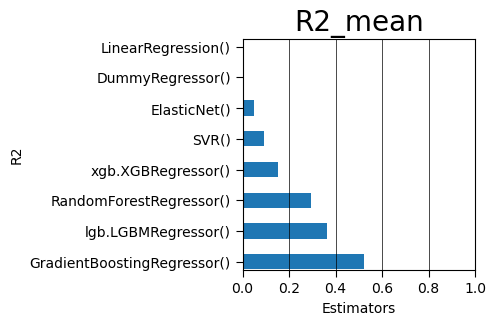

,Estimator,Fold_1_R2,Fold_2_R2,Fold_3_R2,Fold_4_R2,Fold_5_R2,R2_mean,Time_mean,RMSE_mean
5,GradientBoostingRegressor(),0.468099,0.745385,0.743595,0.216205,0.436017,0.521860,3.671400,465.005383
7,lgb.LGBMRegressor(),0.344679,0.661110,0.330255,0.212863,0.261328,0.362047,0.425645,555.517500
4,RandomForestRegressor(),0.444415,-0.015612,0.556732,0.165978,0.317585,0.293819,1.639300,543.155057
6,xgb.XGBRegressor(),-0.064463,0.305794,-0.069132,0.169949,0.429513,0.154332,0.615753,616.426195
3,SVR(),0.084233,0.185115,0.070290,0.095613,0.022876,0.091625,0.038777,653.978915
2,ElasticNet(),0.222607,-0.421124,0.198053,0.174005,0.077244,0.050157,0.002118,639.934787
0,DummyRegressor(),-0.033886,-0.110610,-0.040804,-0.051509,-0.027596,-0.052881,0.000386,693.385175
1,LinearRegression(),0.282430,-2.045413,0.286818,0.138321,0.104039,-0.246761,0.000552,659.596415


In [22]:
regression_results_data = pd.DataFrame()
regression_results_data['Estimator'] = split_dict['Fold_1'][4]['Estimator']
for key, values in split_dict.items():
    regression_results_data[key+'_R2'] = values[4].loc[:,'R2']
    regression_results_data[key+'_time'] = values[4].loc[:,'Time_min']
    regression_results_data[key+'_rmse'] = values[4].loc[:,'RMSE']

regression_results_data['R2_mean'] = (regression_results_data.loc[:,['R2' in x for x in regression_results_data.columns]]).mean(axis=1)
regression_results_data['Time_mean'] = (regression_results_data.loc[:,['time' in x for x in regression_results_data.columns]]).mean(axis=1)
regression_results_data['RMSE_mean'] = (regression_results_data.loc[:,['rmse' in x for x in regression_results_data.columns]]).mean(axis=1)

regression_results_data = regression_results_data.drop(columns = regression_results_data.loc[:,['time' in x for x in regression_results_data.columns]].columns)
regression_results_data = regression_results_data.drop(columns = regression_results_data.loc[:,['rmse' in x for x in regression_results_data.columns]].columns)



r2_mean_barplot(regression_results_data.sort_values('R2_mean', ascending=False))
regression_results_data.sort_values('R2_mean', ascending=False)



## 3. EnergyStarScore

### 3.1 Best estimator and best param grid

In [23]:
features.append('ENERGYSTARScore')

Estimator = (regression_results_data.sort_values('R2_mean', ascending=False, ignore_index=True)).loc[0,'Estimator']
param = pd.DataFrame(param_DataFrame_dic[Estimator].mode().iloc[0,3:])
param_grid = {param.index[i]:[param.iloc[i,0]] for i in range(len(param))}

### 3.2 EnergyStarScore not NaN



Fold_1
R2 score : 0.8415251146864039



Permutation explainer: 199it [00:57,  2.98it/s]                         


,Feature,Feature_Importance
0,PropertyGFATotal,132.399711
1,Electricity(kBtu)_%,94.829626
2,ENERGYSTARScore,29.788801
3,NumberofBuildings,20.393333
4,OSEBuildingID,12.288238
5,SiteEnergyUse(kBtu)_%,9.731123
6,OTHER,9.147027
7,NumberofFloors,6.619015
8,STORE_WAREHOUSE,5.833451
9,SteamUse(kBtu)_%,5.114025


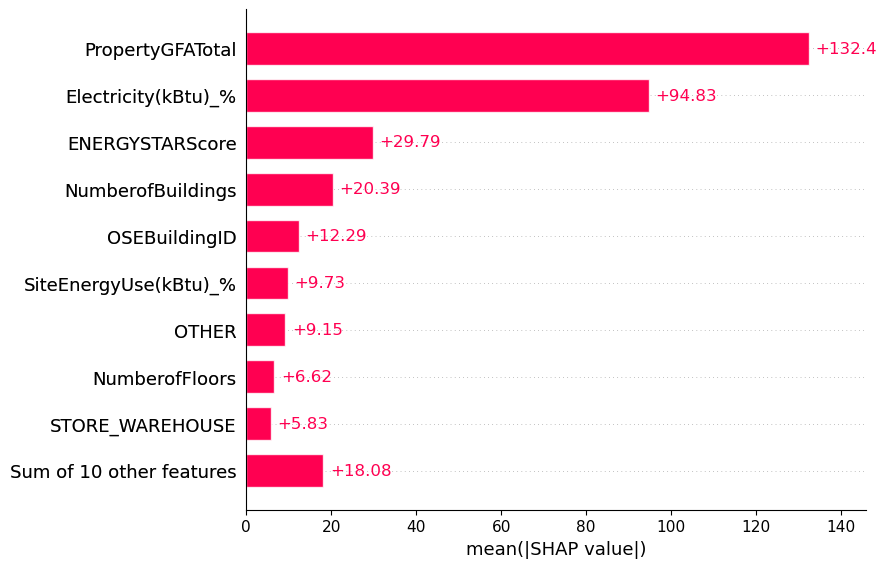



Fold_2
R2 score : 0.41268791917790415



Permutation explainer: 199it [00:50,  3.17it/s]                         


,Feature,Feature_Importance
0,PropertyGFATotal,157.130801
1,Electricity(kBtu)_%,118.914024
2,ENERGYSTARScore,27.710358
3,NumberofBuildings,17.993568
4,SiteEnergyUse(kBtu)_%,14.297932
5,NumberofFloors,10.884573
6,STORE_WAREHOUSE,5.769934
7,OTHER,5.429171
8,OSEBuildingID,5.108463
9,Longitude,5.035878


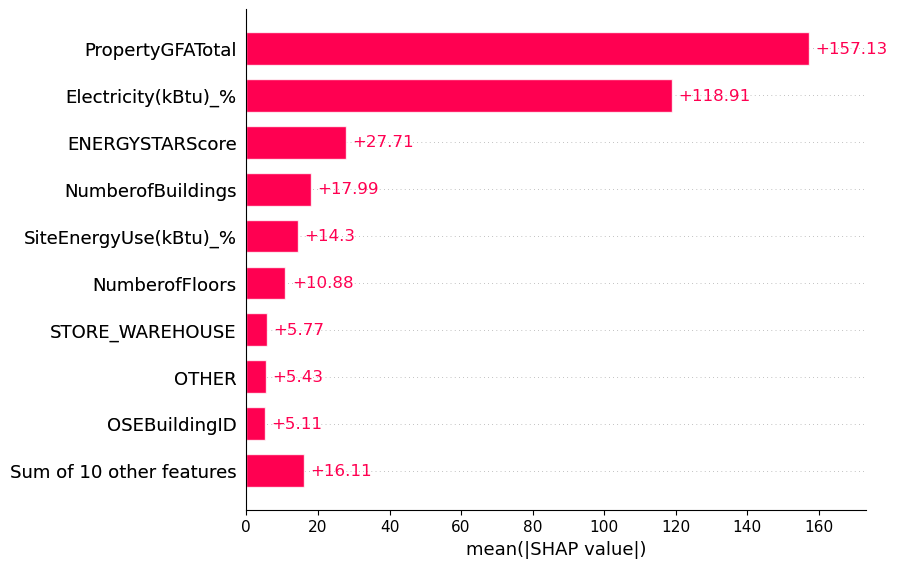



Fold_3
R2 score : 0.7424549627755274



Permutation explainer: 198it [00:52,  3.05it/s]                         


,Feature,Feature_Importance
0,PropertyGFATotal,120.356794
1,Electricity(kBtu)_%,89.132240
2,ENERGYSTARScore,27.647438
3,SteamUse(kBtu)_%,17.264936
4,OSEBuildingID,15.927550
5,SiteEnergyUse(kBtu)_%,14.423579
6,NumberofBuildings,11.728072
7,OTHER,10.671621
8,NumberofFloors,8.292527
9,Longitude,5.591008


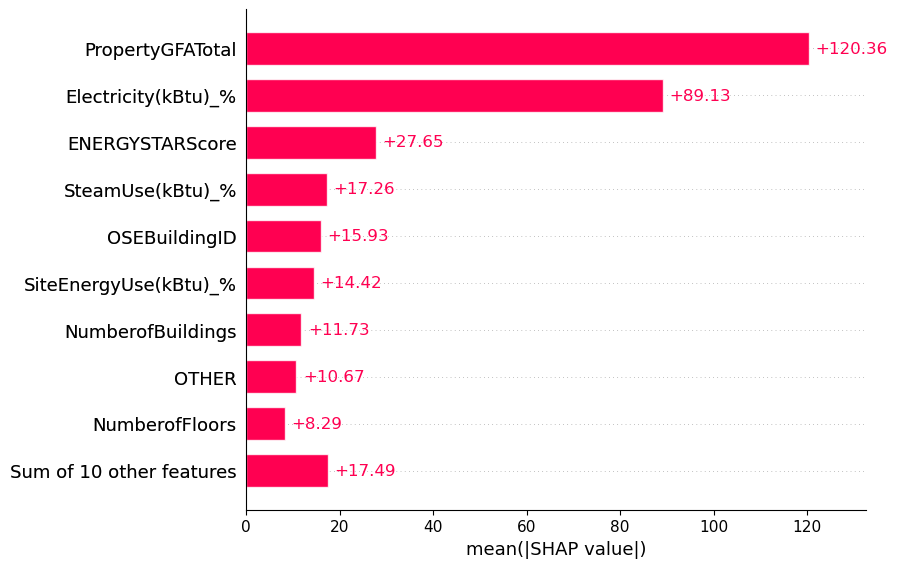



Fold_4
R2 score : 0.46694318310551564



Permutation explainer: 198it [00:52,  3.06it/s]                         


,Feature,Feature_Importance
0,PropertyGFATotal,148.932744
1,Electricity(kBtu)_%,81.131888
2,ENERGYSTARScore,21.751805
3,SteamUse(kBtu)_%,16.795428
4,SiteEnergyUse(kBtu)_%,12.361819
5,YearBuilt,11.081450
6,NumberofFloors,10.926366
7,OSEBuildingID,9.461404
8,OTHER,7.707055
9,Longitude,6.900897


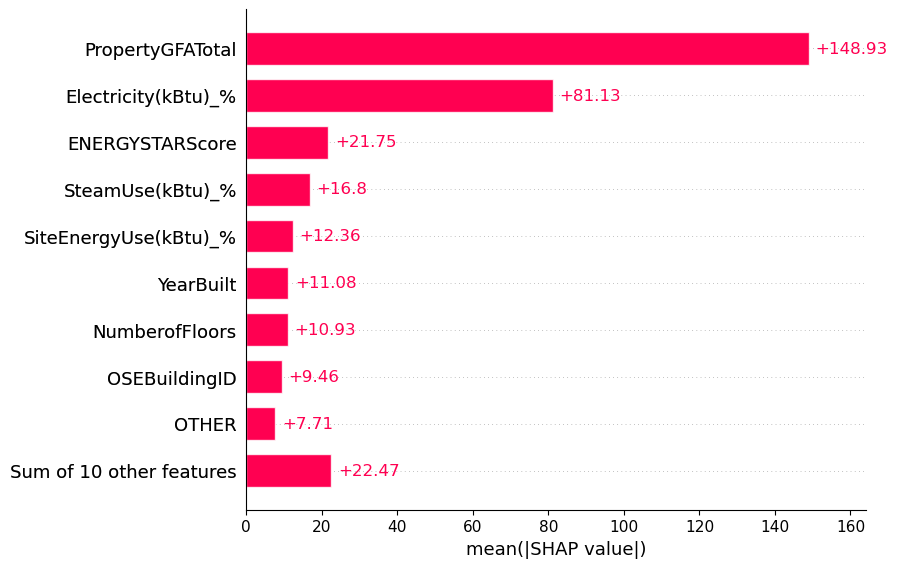



Fold_5
R2 score : 0.19902151555955816



Permutation explainer: 198it [00:55,  2.94it/s]                         


,Feature,Feature_Importance
0,PropertyGFATotal,127.270570
1,Electricity(kBtu)_%,99.318803
2,ENERGYSTARScore,22.156282
3,SiteEnergyUse(kBtu)_%,14.467374
4,NumberofFloors,12.547093
5,SteamUse(kBtu)_%,7.756812
6,OSEBuildingID,7.000270
7,OTHER,4.680130
8,STORE_WAREHOUSE,4.607157
9,Districts_Neighborhood_taget_encoded,3.088714


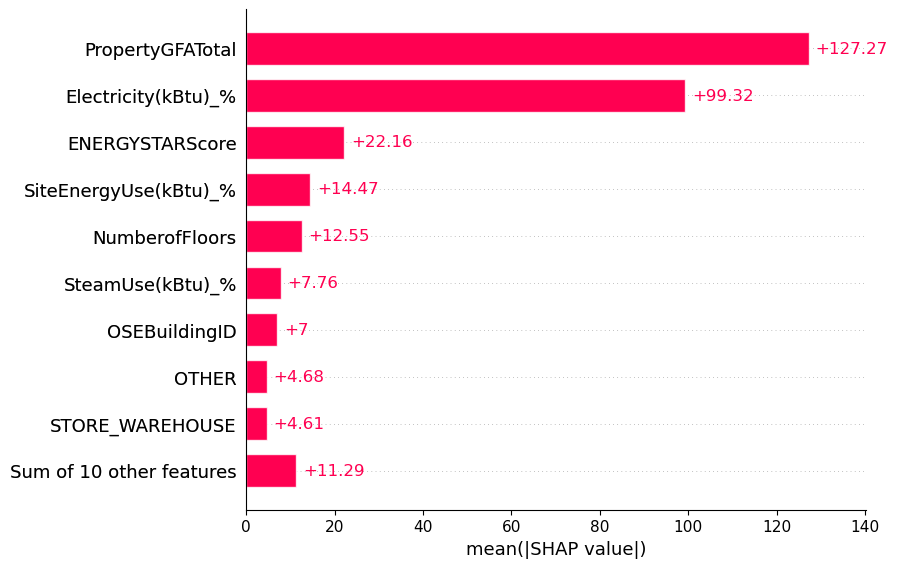

,Estimator,Fold_1_R2,Fold_2_R2,Fold_3_R2,Fold_4_R2,Fold_5_R2,R2_mean,Time_mean,RMSE_mean
8,GradientBoostingRegressor()_notna_EnergyStarScore,0.841525,0.412688,0.742455,0.466943,0.199022,0.532527,0.334249,568.498564
5,GradientBoostingRegressor(),0.468099,0.745385,0.743595,0.216205,0.436017,0.521860,3.671400,465.005383
7,lgb.LGBMRegressor(),0.344679,0.661110,0.330255,0.212863,0.261328,0.362047,0.425645,555.517500
4,RandomForestRegressor(),0.444415,-0.015612,0.556732,0.165978,0.317585,0.293819,1.639300,543.155057
6,xgb.XGBRegressor(),-0.064463,0.305794,-0.069132,0.169949,0.429513,0.154332,0.615753,616.426195
3,SVR(),0.084233,0.185115,0.070290,0.095613,0.022876,0.091625,0.038777,653.978915
2,ElasticNet(),0.222607,-0.421124,0.198053,0.174005,0.077244,0.050157,0.002118,639.934787
0,DummyRegressor(),-0.033886,-0.110610,-0.040804,-0.051509,-0.027596,-0.052881,0.000386,693.385175
1,LinearRegression(),0.282430,-2.045413,0.286818,0.138321,0.104039,-0.246761,0.000552,659.596415


,Fold,shap_rank,shap_value
0,Fold_1,3,29.788801
1,Fold_2,3,27.710358
2,Fold_3,3,27.647438
3,Fold_4,3,21.751805
4,Fold_5,3,22.156282


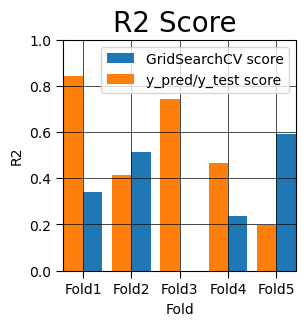

In [24]:
data_notna = df.loc[df['ENERGYSTARScore'].notna()]
data_notna.reset_index(inplace=True) 

regression_results_data, EnergyStarScore_notna_shap_df, EnergyStarScore_notna_dict, R2_score_GridSearchCV_notna = regression_with_EnergyStarScore(data_notna, features, y_feature, Estimator, param_grid,'_notna_EnergyStarScore',regression_results_data)

display(regression_results_data.sort_values('R2_mean', ascending=False))
display(EnergyStarScore_notna_shap_df)

plot_r2_score(R2_score_GridSearchCV_notna)

### 3.3 EnergyStarScore median



Fold_1
R2 score : 0.3937413604021366



Permutation explainer: 306it [01:20,  3.37it/s]                         


,Feature,Feature_Importance
0,PropertyGFATotal,110.610680
1,Electricity(kBtu)_%,76.963203
2,SiteEnergyUse(kBtu)_%,16.693387
3,ENERGYSTARScore,15.698205
4,SteamUse(kBtu)_%,11.920560
5,NumberofFloors,6.379877
6,OSEBuildingID,6.073809
7,STORE_WAREHOUSE,4.869820
8,OTHER,4.109960
9,YearBuilt,2.891748


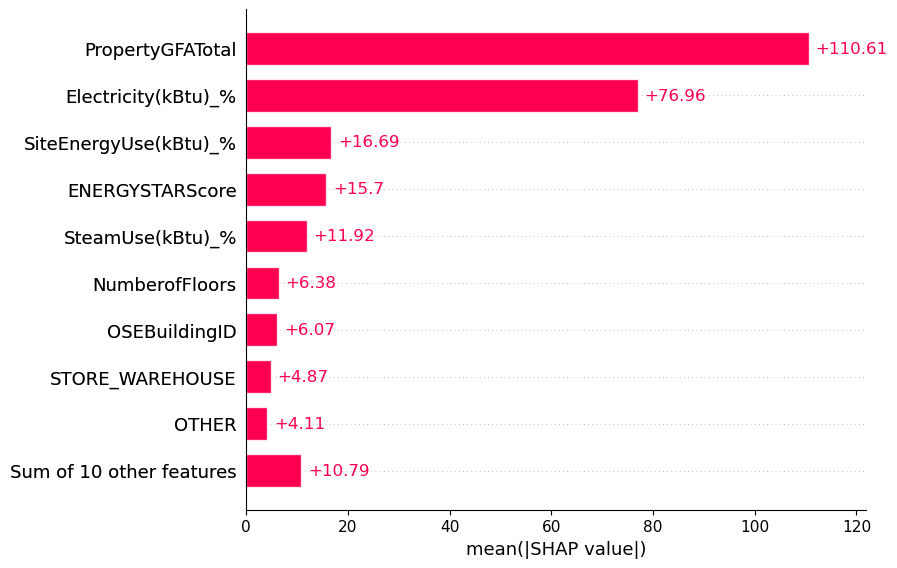



Fold_2
R2 score : 0.6819161019152107



Permutation explainer: 306it [01:16,  3.48it/s]                         


,Feature,Feature_Importance
0,PropertyGFATotal,162.390891
1,Electricity(kBtu)_%,106.920228
2,SiteEnergyUse(kBtu)_%,17.294269
3,ENERGYSTARScore,16.536738
4,SteamUse(kBtu)_%,15.993882
5,OSEBuildingID,7.844039
6,STORE_WAREHOUSE,7.279694
7,NumberofBuildings,5.960045
8,YearBuilt,4.487740
9,OTHER,4.467744


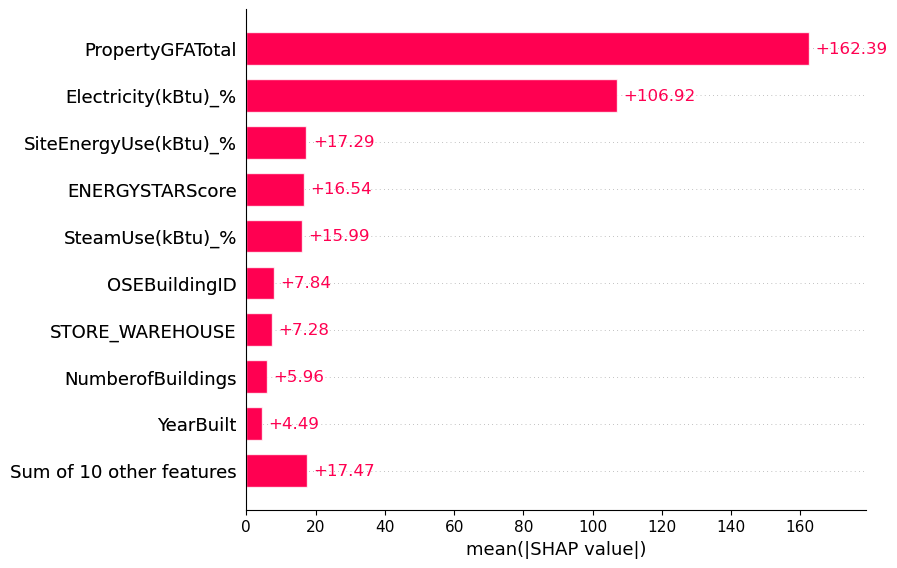



Fold_3
R2 score : 0.39311947391540003



Permutation explainer: 306it [01:16,  3.46it/s]                         


,Feature,Feature_Importance
0,PropertyGFATotal,152.733010
1,Electricity(kBtu)_%,114.094519
2,ENERGYSTARScore,17.897293
3,SiteEnergyUse(kBtu)_%,16.084449
4,NumberofBuildings,15.053206
5,OSEBuildingID,8.925639
6,NumberofFloors,6.326375
7,STORE_WAREHOUSE,5.533350
8,SteamUse(kBtu)_%,4.836240
9,Longitude,2.946355


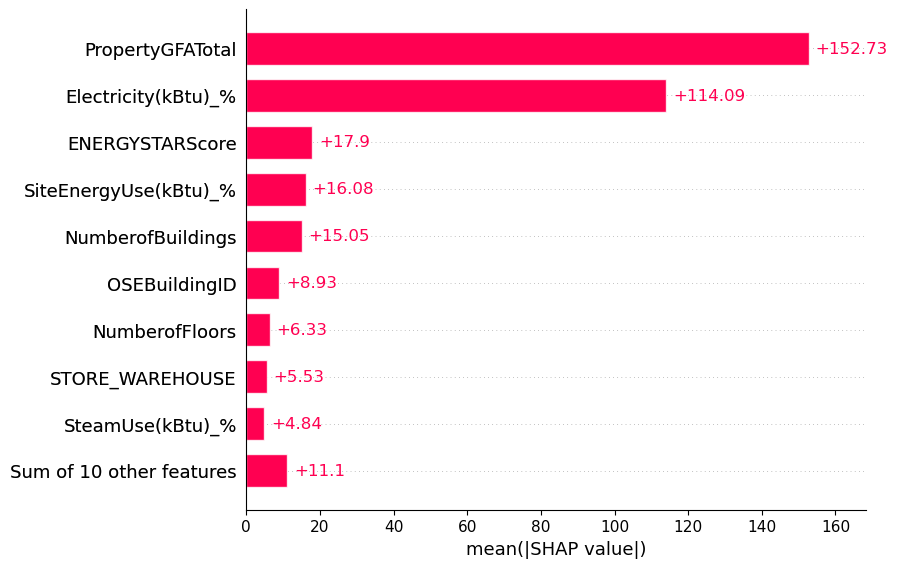



Fold_4
R2 score : 0.8669870522213355



Permutation explainer: 306it [01:17,  3.44it/s]                         


,Feature,Feature_Importance
0,PropertyGFATotal,125.302251
1,Electricity(kBtu)_%,106.402120
2,SiteEnergyUse(kBtu)_%,15.514024
3,ENERGYSTARScore,14.552820
4,OSEBuildingID,8.672685
5,NumberofBuildings,7.291457
6,STORE_WAREHOUSE,5.718302
7,NumberofFloors,5.519662
8,SteamUse(kBtu)_%,4.560990
9,Longitude,3.833807


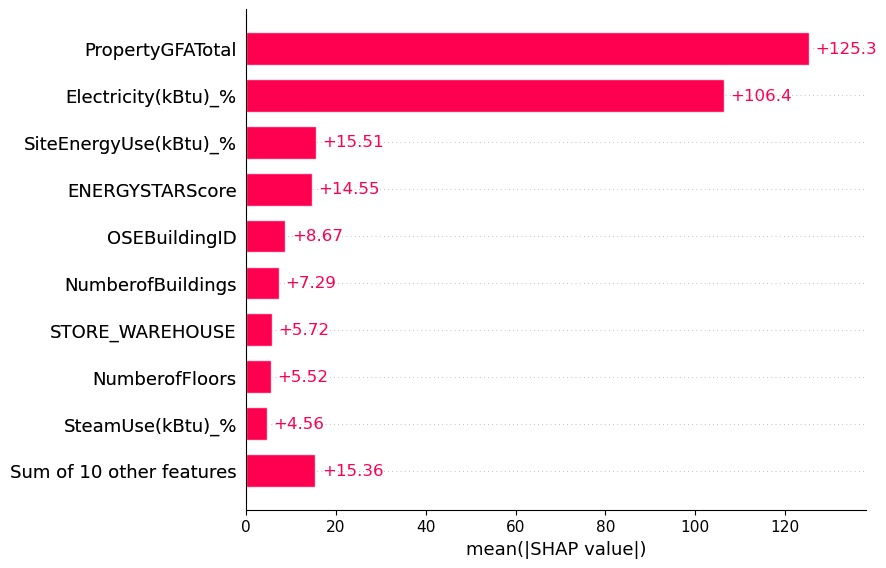



Fold_5
R2 score : 0.7204865755019743



Permutation explainer: 306it [01:18,  3.41it/s]                         


,Feature,Feature_Importance
0,PropertyGFATotal,157.016313
1,Electricity(kBtu)_%,103.983000
2,SiteEnergyUse(kBtu)_%,19.484199
3,ENERGYSTARScore,19.467931
4,NumberofBuildings,15.200501
5,NumberofFloors,12.825394
6,OTHER,10.212571
7,OSEBuildingID,9.993284
8,STORE_WAREHOUSE,6.866300
9,SteamUse(kBtu)_%,5.102521


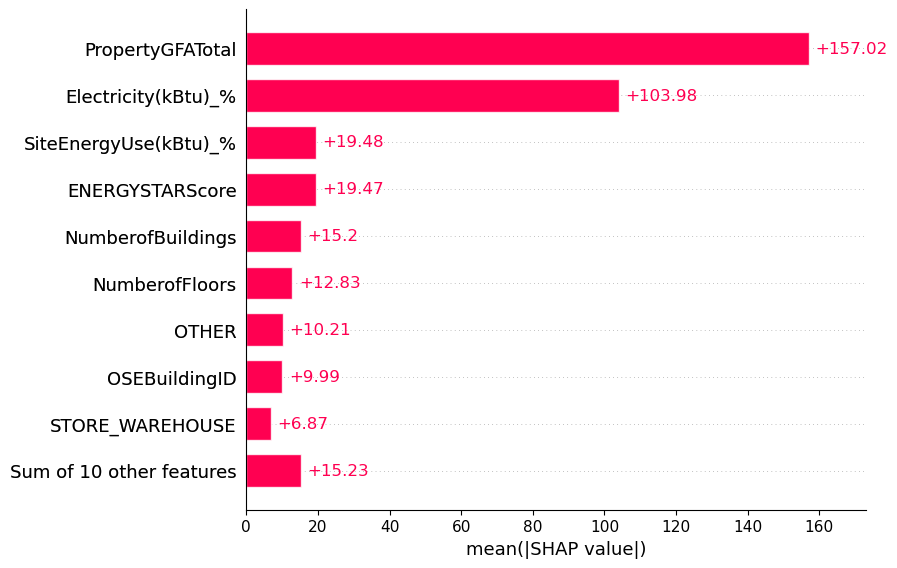

,Fold,shap_rank,shap_value
0,Fold_1,4,15.698205
1,Fold_2,4,16.536738
2,Fold_3,3,17.897293
3,Fold_4,4,14.552820
4,Fold_5,4,19.467931


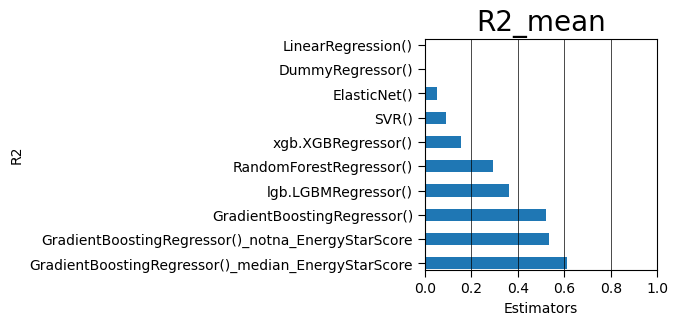

,Estimator,Fold_1_R2,Fold_2_R2,Fold_3_R2,Fold_4_R2,Fold_5_R2,R2_mean,Time_mean,RMSE_mean
9,GradientBoostingRegressor()_median_EnergyStarS...,0.393741,0.681916,0.393119,0.866987,0.720487,0.611250,0.383502,434.431496
8,GradientBoostingRegressor()_notna_EnergyStarScore,0.841525,0.412688,0.742455,0.466943,0.199022,0.532527,0.334249,568.498564
5,GradientBoostingRegressor(),0.468099,0.745385,0.743595,0.216205,0.436017,0.521860,3.671400,465.005383
7,lgb.LGBMRegressor(),0.344679,0.661110,0.330255,0.212863,0.261328,0.362047,0.425645,555.517500
4,RandomForestRegressor(),0.444415,-0.015612,0.556732,0.165978,0.317585,0.293819,1.639300,543.155057
6,xgb.XGBRegressor(),-0.064463,0.305794,-0.069132,0.169949,0.429513,0.154332,0.615753,616.426195
3,SVR(),0.084233,0.185115,0.070290,0.095613,0.022876,0.091625,0.038777,653.978915
2,ElasticNet(),0.222607,-0.421124,0.198053,0.174005,0.077244,0.050157,0.002118,639.934787
0,DummyRegressor(),-0.033886,-0.110610,-0.040804,-0.051509,-0.027596,-0.052881,0.000386,693.385175
1,LinearRegression(),0.282430,-2.045413,0.286818,0.138321,0.104039,-0.246761,0.000552,659.596415


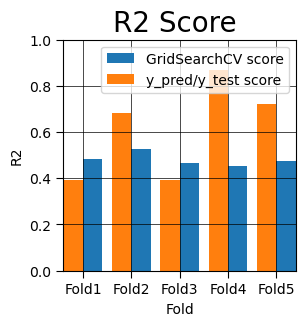

In [25]:
data_median = pd.DataFrame(df)
data_median.loc[data_median['ENERGYSTARScore'].isna(),'ENERGYSTARScore'] = data_median.loc[data_median['ENERGYSTARScore'].notna(),'ENERGYSTARScore'].median()
data_median.reset_index(inplace=True)


regression_results_data, EnergyStarScore_median_shap_df, EnergyStarScore_median_dict, R2_score_GridSearchCV_median = regression_with_EnergyStarScore(data_median, features, y_feature, Estimator, param_grid,'_median_EnergyStarScore',regression_results_data)


display(EnergyStarScore_median_shap_df)

r2_mean_barplot(regression_results_data.sort_values('R2_mean', ascending=False))
display(regression_results_data.sort_values('R2_mean', ascending=False))

plot_r2_score(R2_score_GridSearchCV_median)

### 3.4 Overfitting

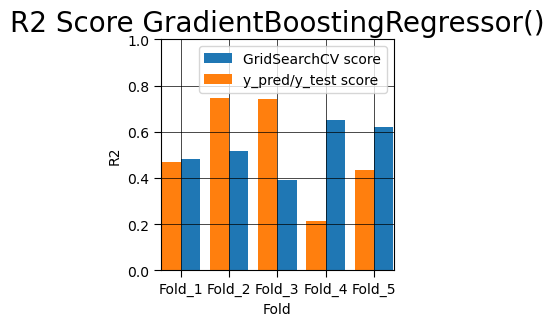

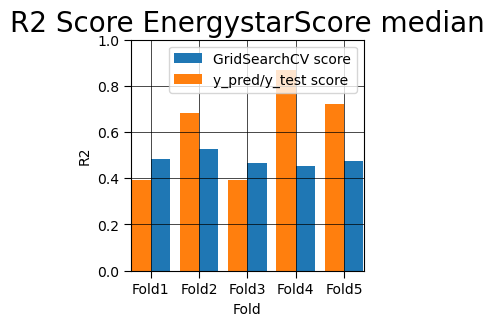

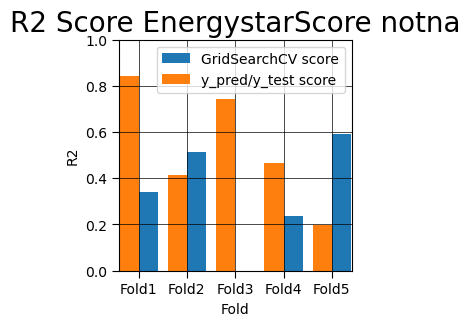

In [27]:
plot_r2_score(param_DataFrame_dic[Estimator],title=Estimator)

plot_r2_score(R2_score_GridSearchCV_median, title='EnergystarScore median' )

plot_r2_score(R2_score_GridSearchCV_notna, title='EnergystarScore notna')